In [282]:
import pandas as pd
import math
from sklearn import preprocessing
import seaborn as sns
import numpy as np
import scipy as sp
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 500)

In [291]:
train = pd.read_csv('../data/clean_train_all_cols_chase.csv', parse_dates=['timestamp'],index_col="id")  #,index_col="id"
test = pd.read_csv("../data/clean_test_all_cols_chase.csv", parse_dates=['timestamp'],index_col="id")
# locales = pd.read_csv('../data/okurg_chase.csv')
gold = pd.read_csv('../data/gold_district.csv')

# train = pd.read_csv('../data/clean_train_all_cols_chase.csv', parse_dates=['timestamp'], index_col="id")  
# test = pd.read_csv('../data/clean_test_all_cols_chase.csv', parse_dates=['timestamp'], index_col="id")

# macro = pd.read_csv('../data/district_indices.csv')
# indices = pd.read_csv('../data/district_indices.csv')

In [292]:
# gold.columns = ['month_year','nominal_index']

In [293]:
train_index = train.index.tolist()
test_index = test.index.tolist()

# cols = ['life_sq','full_sq','floor','max_floor','kitch_sq','product_type',
#         'sub_area','kremlin_km','price_doc','timestamp']

tr_cols = train.columns.tolist()
te_cols = test.columns.tolist()
cols = set(tr_cols).intersection(te_cols)
cols = list(cols)
cols.append('price_doc')

test['price_doc'] = np.nan

df = pd.concat([train[cols].copy(),
                test[cols].copy()],
               ignore_index=False)


# df['month'] = df.timestamp.dt.month.astype(object)
# df['quarter'] = pd.PeriodIndex(df['timestamp'], freq='Q').strftime('Q%q/%y')
# macro['quarter'] = pd.PeriodIndex(macro['Unnamed: 0'], freq='Q').strftime('Q%q/%y')

# df = pd.merge(df,macro[['quarter','nominal_index']], how="left", on="quarter").reset_index(drop=True).set_index(df.index)


df['month_year'] = pd.PeriodIndex(df['timestamp'], freq='M').strftime('%m/%y')
# macro['month_year'] = pd.PeriodIndex(macro['month_year'], freq='M').strftime('%m/%y')

# df = pd.merge(df,gold[['month_year','nominal_index']], how="left", on="month_year").reset_index(drop=True).set_index(df.index)

# df = pd.merge(df,locales[['sub_area','okurg_district']],how="left",on='sub_area').reset_index(drop=True).set_index(df.index)

In [303]:
temp = df[['okurg_district','month_year']]
gold.set_index('month_year',inplace=True)

In [308]:
temp['nominal_index'] = temp.apply(lambda x: gold.loc[x[1], x[0]], axis=1)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [309]:
df['nominal_index'] = temp['nominal_index']

In [310]:
# df['price_doc'] = df.price_doc / df.nominal_index
# df['price_full'] = df.price_doc / df.full_sq

# ## dropping outliers
# outliers = df[df.price_full < 50000].copy()
# df.drop(outliers.index,axis=0, inplace=True)
# for x in outliers.index.tolist():
#     train_index.remove(x)

# df['log_price'] = np.log(df.price_doc)
# df['log_price_full'] = np.log(df.price_full)
# # df['price_doc'] = df.price_doc / 1000

In [311]:
df.shape

(36758, 297)

In [312]:
df.loc[df.build_year < 1850,'build_year'] = np.nan

In [313]:
df.loc[df.state>5,'state'] = np.nan

In [339]:
df.state = df.state.astype(object)
df['price_full'] = df.price_doc / df.full_sq

### Helper functions

In [340]:
def getKremlinGroup(df, id):
    """ returns the group that are the same distance from the kremlin"""
    x = df.loc[id,'kremlin_km']
    return df.loc[df.kremlin_km==x,:]

In [341]:
df_train = df.loc[train_index,:]
df_test = df.loc[test_index,:]

In [342]:
pd.concat([df_train, df_test]).shape

(36758, 298)

In [343]:
# ylog will be log(1+y), as suggested by https://github.com/dmlc/xgboost/issues/446#issuecomment-135555130
ylog_train_all = np.log1p(df_train['price_full'].values)


df_train.drop(['price_doc','price_full'], axis=1, inplace=True)

# Build df_all = (df_train+df_test).join(df_macro)
num_train = len(df_train)
df_all = pd.concat([df_train, df_test])
# df_all['quarter'] = pd.PeriodIndex(df['timestamp'], freq='Q').strftime('Q%q-%y')

print(df_all.shape)

# Add month-year
month_year = (df_all.timestamp.dt.month + df_all.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df_all['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (df_all.timestamp.dt.weekofyear + df_all.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df_all['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
df_all['month'] = df_all.timestamp.dt.month
df_all['dow'] = df_all.timestamp.dt.dayofweek

# Other feature engineering
df_all['rel_floor'] = df_all['floor'] / df_all['max_floor'].astype(float)
df_all['rel_kitch_sq'] = df_all['kitch_sq'] / df_all['full_sq'].astype(float)

# Remove timestamp column (may overfit the model in train)
df_all.drop(['timestamp','month_year'], axis=1, inplace=True)

(36758, 298)


In [344]:
# df_all.drop('timestamp', axis=1, inplace=True)

In [345]:
df_all.loc[df_all.build_year<1,'build_year'] = np.nan

In [346]:
df_all.loc[(df_all.num_room==1) & (df_all.full_sq>40),'num_room'] = np.nan

In [347]:
# Deal with categorical values
df_numeric = df_all.select_dtypes(exclude=['object'])
df_obj = df_all.select_dtypes(include=['object']).copy()

for c in df_obj:
    df_obj[c] = pd.factorize(df_obj[c])[0]

df_values = pd.concat([df_numeric, df_obj], axis=1)

In [348]:
# Convert to numpy values
X_all = df_values.values
print(X_all.shape)

# Create a validation set, with last 20% of data
num_val = int(num_train * 0.2)

X_train_all = X_all[:num_train]
X_train = X_all[:num_train-num_val]
X_val = X_all[num_train-num_val:num_train]
ylog_train = ylog_train_all[:-num_val]
ylog_val = ylog_train_all[-num_val:]

X_test = X_all[num_train:]

df_columns = df_values.columns

print('X_train_all shape is', X_train_all.shape)
print('X_train shape is', X_train.shape)
print('y_train shape is', ylog_train.shape)
print('X_val shape is', X_val.shape)
print('y_val shape is', ylog_val.shape)
print('X_test shape is', X_test.shape)

(36758, 302)
('X_train_all shape is', (29096, 302))
('X_train shape is', (23277, 302))
('y_train shape is', (23277,))
('X_val shape is', (5819, 302))
('y_val shape is', (5819,))
('X_test shape is', (7662, 302))


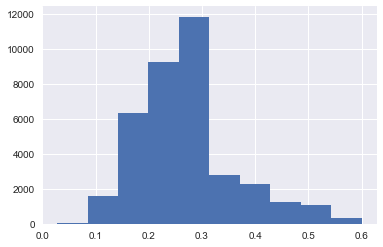

In [349]:
df.kitch_to_life.hist()

In [350]:
dtrain_all = xgb.DMatrix(X_train_all, ylog_train_all, feature_names=df_columns)
dtrain = xgb.DMatrix(X_train, ylog_train, feature_names=df_columns)
dval = xgb.DMatrix(X_val, ylog_val, feature_names=df_columns)
dtest = xgb.DMatrix(X_test, feature_names=df_columns)

In [351]:
# Deal with categorical values
df_numeric = df_all.select_dtypes(exclude=['object'])
df_obj = df_all.select_dtypes(include=['object']).copy()

for c in df_obj:
    df_obj[c] = pd.factorize(df_obj[c])[0]

df_values = pd.concat([df_numeric, df_obj], axis=1)

In [352]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1,
    'n_jobs': -1
}

# Uncomment to tune XGB `num_boost_rounds`
partial_model = xgb.train(xgb_params, dtrain, num_boost_round=1000, evals=[(dval, 'val')],
                       early_stopping_rounds=20, verbose_eval=20)

num_boost_round = partial_model.best_iteration

[0]	val-rmse:10.7513
Will train until val-rmse hasn't improved in 20 rounds.
[20]	val-rmse:3.92175
[40]	val-rmse:1.48504
[60]	val-rmse:0.646838
[80]	val-rmse:0.399997
[100]	val-rmse:0.337981
[120]	val-rmse:0.321679
[140]	val-rmse:0.316639
[160]	val-rmse:0.314655
[180]	val-rmse:0.313828
[200]	val-rmse:0.31358
[220]	val-rmse:0.313104
[240]	val-rmse:0.313172
Stopping. Best iteration:
[231]	val-rmse:0.312944



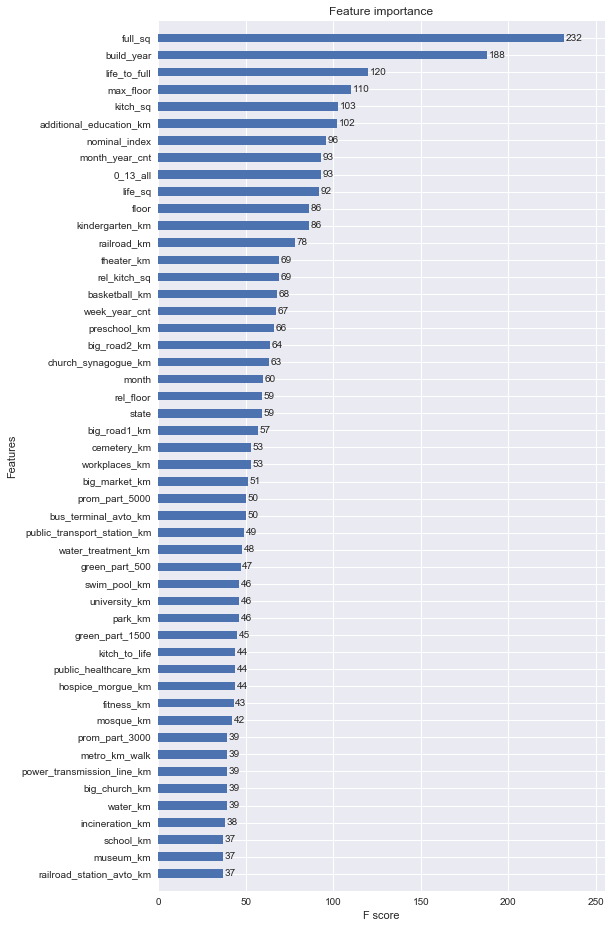

In [353]:
fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(partial_model, max_num_features=50, height=0.5, ax=ax)

In [354]:
num_boost_round = partial_model.best_iteration

In [355]:
model = xgb.train(dict(xgb_params, silent=0), dtrain_all, num_boost_round=num_boost_round)

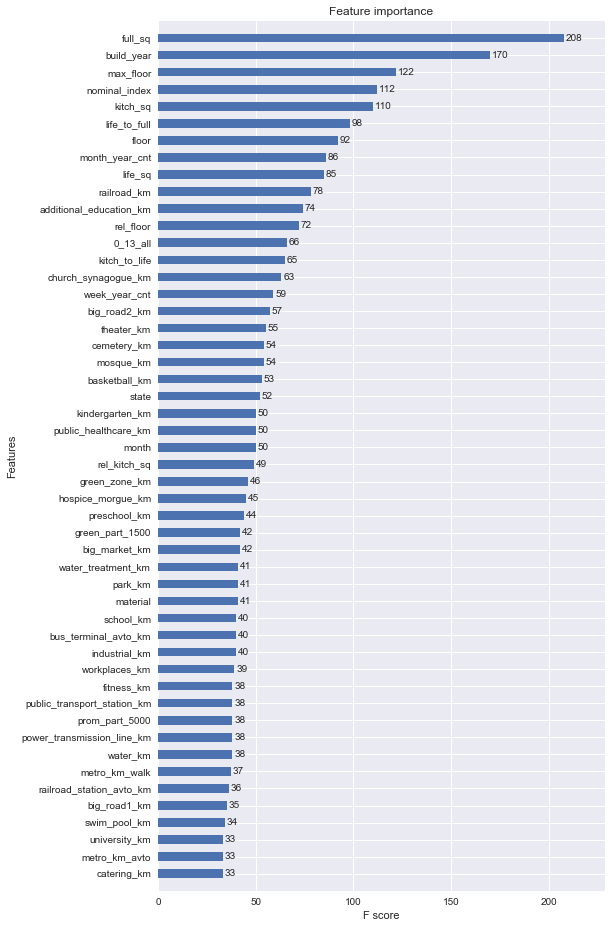

In [356]:
fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

In [358]:
ylog_pred = model.predict(dtest)
y_pred = np.exp(ylog_pred) - 1

df_sub = pd.DataFrame({'id': test_index, 
                       'price_full': y_pred,
                       'full_sq': df.loc[test_index,'full_sq'], 
                       'nominal_index': df.loc[test_index,'nominal_index']})

In [360]:
df_sub['price_doc'] = df_sub.price_full * df.full_sq

In [361]:
# df_sub['price_doc'] = df_sub.price_doc #* df.nominal_index
df_sub['price_full'] = df_sub.price_doc / df_sub.full_sq 

141766.234375


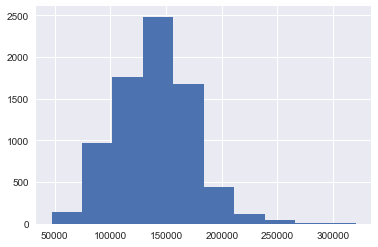

In [362]:
print df_sub.price_full.median()
df_sub.price_full.hist()

In [363]:
# 0.32046
df_sub[['price_doc']].to_csv('../submissions/sub_XGB_gold_0530_330PM.csv')

In [303]:
df_sub.index=id_test

In [304]:
df_sub['timestamp'] = df_test.timestamp

In [305]:
df_sub['quarter'] = pd.PeriodIndex(df_test.timestamp, freq='Q').strftime('Q%q-%y')

In [306]:
df_sub = pd.merge_ordered(df_sub, df_macro[['nominal_index','quarter']], on='quarter', how='left')

In [307]:
df_sub.price_doc = df_sub.price_doc * df_sub.nominal_index

In [310]:
df_sub.drop(['timestamp','quarter','nominal_index'],axis=1).to_csv('../submissions/sub0524_1116PM.csv')